In [0]:
# Smart Grid Peak Tariff Optimization Problem
# Author: Himanshu Mishra & Serg Masis
# Version: 1.0 (30.10.2019)
# License: MIT
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0

# Smart Grid Peak Tariff Optimization Problem

### Import some libraries

In [0]:
import numpy as np
import matplotlib
import math
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

#Tqdm is used to show nice progress bars while the RL agent is going through its learning process.
from tqdm import tqdm 

#To ignore warnings that are annoying.
import warnings
warnings.filterwarnings('ignore')

## Set Up

We assume $N=3$ values of possible states in the teriff plan, and assume $T=365$ time steps. All combinations of state and time can then be represented as a two-dimensional grid of size $N\times T = 3\times 365$. A time dependent action value function $Q_t\left( s_t, a_t\right)$ with three possible actions, $a_t = \{a_{\text{normal_high}}, a_{\text{normal_low}}, a_{\text{high_high}}, a_{\text{high_low}}, a_{\text{normal}}\}$, can then be stored as a rank three tensor of dimension $3\times 365 \times 5$.

#### Setting up some global parameters

In [0]:
# N - World height
# T - World width
WORLD_HEIGHT = 3 #Outcome
WORLD_WIDTH = 365 #Timestep

In [0]:
# Probability for exploration - epsilon
EPSILON = 0.1
# Step size
ALPHA = 0.001
# Gamma - discount factor - for Q-Learning, Sarsa and Expected Sarsa
GAMMA = 1

In [0]:
# Actions - ACTION_INCREASE is a+ (changing the state to High Teriff), ACTION_DECREASE is a-(changing the state to Low Teriff ), 
# ACTION_NORMAL is a_n (changing the state to High Teriff Normal) and ACTION_NORMAL is a_c (keeping the action same)
ACTION_NORMAL_HIGH = 1
ACTION_NORMAL_LOW = 2
ACTION_HIGH_HIGH = 3
ACTION_HIGH_LOW = 4
ACTION_NORMAL = 0
ACTIONS = [ACTION_NORMAL, ACTION_NORMAL_HIGH, ACTION_NORMAL_LOW, ACTION_HIGH_HIGH, ACTION_HIGH_LOW, ACTION_NORMAL]

In [0]:
OUTCOME_ON_TARGET = 0
OUTCOME_BELOW_TARGET = 1
OUTCOME_ABOVE_TARGET = 2
OUTCOMES = [OUTCOME_ON_TARGET, OUTCOME_BELOW_TARGET, OUTCOME_ABOVE_TARGET]

In [0]:
# Initial and Goal states
START = [0, 0]
GOAL = [0, WORLD_WIDTH-1]

In [0]:
Yhat = np.array([0.65297133, 0.82016883, 0.82536817, 0.82404125, 0.74340858,
       0.7504175 , 0.87447417, 0.87102508, 0.91692508, 0.98034925,
       0.96322383, 0.84697525, 0.83656625, 1.00987717, 1.07333258,
       1.06141483, 1.02909792, 0.93805308, 0.88046767, 0.87288767,
       0.93864892, 1.01303008, 1.0437205 , 1.03290592, 0.90761042,
       0.81071767, 0.716652  , 0.86293842, 0.84405567, 0.82409892,
       0.84724292, 0.89270142, 0.60150917, 0.75992558, 0.813392  ,
       0.84773133, 0.87079942, 0.95465825, 0.94436533, 0.89073867,
       0.7964505 , 0.94012217, 1.00120592, 0.97547983, 0.92525775,
       0.92398658, 0.830184  , 0.78101483, 0.9176275 , 0.94888075,
       0.906498  , 0.936746  , 0.97941   , 0.89535308, 0.85149617,
       0.96652475, 0.98847142, 0.97427425, 0.96749442, 0.94183242,
       0.85277708, 0.79917175, 0.91399733, 0.9289505 , 0.90229592,
       0.86963667, 0.84246467, 0.77717683, 0.73809792, 0.91326242,
       0.97580867, 0.93970658, 0.96186167, 0.8871825 , 0.80993992,
       0.81188017, 0.89746033, 0.91240475, 0.93312292, 0.90912275,
       0.84144175, 0.77846025, 0.75558325, 0.89775917, 0.91052825,
       0.96470267, 0.94323208, 0.85712508, 0.81737325, 0.76899108,
       0.75864058, 0.86658417, 0.7218025 , 0.88690342, 0.86851033,
       0.8094075 , 0.7796325 , 0.84017008, 0.87657267, 0.88748975,
       0.87938717, 0.85492333, 0.73211667, 0.61694367, 0.73465642,
       0.72605533, 0.75354142, 0.70602267, 0.7788295 , 0.67214558,
       0.67461858, 0.70931517, 0.74665667, 0.77124425, 0.79691558,
       0.75977608, 0.69446717, 0.6386365 , 0.7146795 , 0.77651217,
       0.76208158, 0.76286375, 0.70620433, 0.59508475, 0.584423  ,
       0.643462  , 0.74181983, 0.70945133, 0.68279667, 0.68279092,
       0.60584425, 0.59721125, 0.66151333, 0.74856325, 0.75472492,
       0.79378025, 0.76026625, 0.67092433, 0.66632508, 0.74963958,
       0.74712942, 0.71599725, 0.7044895 , 0.72693567, 0.65389442,
       0.60013667, 0.59893867, 0.75089392, 0.75606458, 0.75330833,
       0.71222167, 0.62897517, 0.61558642, 0.73243792, 0.69077792,
       0.74731458, 0.73104092, 0.70136358, 0.61333483, 0.612581  ,
       0.74019483, 0.70495258, 0.710764  , 0.67479375, 0.67151   ,
       0.53917308, 0.60905667, 0.73164208, 0.74622708, 0.77099092,
       0.78461492, 0.74493192, 0.55059158, 0.5108015 , 0.70949625,
       0.72306733, 0.74243617, 0.7395105 , 0.70425267, 0.59759583,
       0.53765475, 0.69112283, 0.71013558, 0.7322345 , 0.68454375,
       0.71541075, 0.63311367, 0.62763183, 0.72458958, 0.7407255 ,
       0.70746842, 0.73511283, 0.73638025, 0.40569817, 0.6000925 ,
       0.746157  , 0.75703242, 0.77078033, 0.75917058, 0.73534683,
       0.63857442, 0.6089585 , 0.74712633, 0.78039725, 0.76168658,
       0.7632165 , 0.74701075, 0.66460817, 0.58908817, 0.6884435 ,
       0.70429925, 0.72678417, 0.719862  , 0.68907725, 0.56866525,
       0.59160492, 0.71587692, 0.73039567, 0.73348967, 0.73133542,
       0.68715033, 0.62976333, 0.57843633, 0.67935392, 0.7288665 ,
       0.74281333, 0.71806283, 0.71451225, 0.58432733, 0.58005625,
       0.717944  , 0.74656442, 0.74268475, 0.778816  , 0.73918375,
       0.66600425, 0.62750533, 0.66034083, 0.75000908, 0.76748008,
       0.747263  , 0.70081142, 0.59250992, 0.55995967, 0.68549683,
       0.78144883, 0.77290742, 0.78929958, 0.74979708, 0.61429725,
       0.64589842, 0.79302067, 0.71783675, 0.78354767, 0.80327058,
       0.79693792, 0.66757583, 0.57047025, 0.65974225, 0.7194485 ,
       0.75596   , 0.77123317, 0.75973117, 0.67769342, 0.65175275,
       0.79981167, 0.80555217, 0.78854417, 0.78676283, 0.76620875,
       0.648563  , 0.572627  , 0.70099758, 0.70908817, 0.73424117,
       0.74332392, 0.74618867, 0.67863767, 0.6260635 , 0.74575475,
       0.75681583, 0.70897125, 0.708912  , 0.73654383, 0.68537533,
       0.66642117, 0.80847817, 0.82930558, 0.80945917, 0.809333  ,
       0.77617975, 0.67394042, 0.63312008, 0.75671075, 0.73290833,
       0.6688495 , 0.79879792, 0.70973742, 0.61726133, 0.56658367,
       0.70716292, 0.73176567, 0.76936933, 0.74605067, 0.76657642,
       0.679183  , 0.627388  , 0.8202415 , 0.80879217, 0.83910925,
       0.80637567, 0.84419792, 0.76766567, 0.74194667, 0.80863392,
       0.81146517, 0.80779425, 0.77455167, 0.84521417, 0.76260633,
       0.79017342, 0.87792267, 0.85195725, 0.82162692, 0.86045483,
       0.89541092, 0.83157867, 0.80647875, 0.92236358, 0.87897575,
       0.88001583, 0.91669992, 0.77156308, 0.76212925, 0.78452333,
       0.91482025, 0.9119425 , 0.84579933, 0.83380258, 0.87039267,
       0.76956667, 0.662791  , 0.80875617, 0.84417058, 0.87358825,
       0.85905458, 0.81298783, 0.69169642, 0.67009308, 0.7874245 ,
       0.85447617, 0.78566508, 0.81244567, 0.75542117, 0.64030267,
       0.64067725, 0.73547092, 0.67452258, 0.6241335 , 0.66595058,
       0.65298817, 0.67114458, 0.67635208, 0.68490975, 0.66451275]) #Daily TWh Non-renewable Residential Energy Demand Forecast (UK, 2013)

In [0]:
monthly_variances_adversity = np.array([[1.        , 0.94478474, 1.13028166, 1.01154859, 1.00642762],
       [1.        , 0.99609853, 1.04194803, 0.97084265, 1.0388943 ],
       [1.        , 0.98442389, 1.03894516, 0.97236052, 0.98656826],
       [1.        , 0.99532647, 1.01406848, 0.97103307, 0.95879985],
       [1.        , 0.95906747, 0.9790569 , 0.98020894, 1.001873  ],
       [1.        , 0.97395693, 1.07245554, 0.98267029, 1.0256229 ],
       [1.        , 1.01285538, 1.03548462, 0.96160257, 1.01493072],
       [1.        , 1.0065727 , 1.02650583, 1.01668459, 1.02302871],
       [1.        , 0.9757814 , 1.0204114 , 1.01708173, 1.01348851],
       [1.        , 0.98057395, 1.14533756, 0.99881338, 0.99639876],
       [1.        , 0.9270685 , 1.03921254, 1.00166209, 1.08924898],
       [1.        , 1.03534977, 1.01707886, 1.0063885 , 1.02778647]])

In [0]:
def target(t):
  target = (-0.00000000267168)*(t**3) + (0.0000066387)*(t**2) + (-0.0025185)*t + 0.962437
  
  return(target)

In [0]:
def month_for_day(timestep):
  return math.floor(timestep/30.42)

In [0]:
def month_var():
  var = monthly_variances_adversity.min(axis=1)
  return var

In [0]:
month_min = month_var()
month_min[11]

1.0

#### Setting up the environment

Target is to be $\tau_t \pm \alpha \%$ at any given $t$:

$\tau_t = -0.00000000267168*t^3 + 0.0000066387*t^2 + -0.0025185*t + 0.962437$

In [0]:
def get_estimates(timestep, alpha=0.03):
  month_t = month_for_day(timestep)
  Yhat_t = Yhat[timestep] * monthly_variances_adversity[month_t]
  target_t = target(timestep)
  target_t_max = target_t * (1+alpha)
  target_t_min = target_t * (1-alpha)
  return Yhat_t, target_t_max, target_t_min

In [0]:
def best_action_for_day(timestep, bounded=0, alpha=0.03):
  Yhat_t, target_t_max, target_t_min = get_estimates(timestep, alpha)
  if bounded==0: #Upper and Lower Bounded
    in_target = np.where((Yhat_t > target_t_min) & (Yhat_t <= target_t_max))
  elif bounded==1: #Upper Bounded Only
    in_target = np.where((Yhat_t <= target_t_max))
  else: #Lower Bounded Only
    in_target = np.where((Yhat_t > target_t_min))
  if len(in_target[0]) > 0:
    if bounded <= 0: #For all except upper bounded
      min_in_target = Yhat_t[in_target].min()
      return np.where(Yhat_t == min_in_target)[0][0], min_in_target
    else:
      max_in_target = Yhat_t[in_target].min()
      return np.where(Yhat_t == max_in_target)[0][0], max_in_target
  else:
    return False, Yhat[timestep]

In [0]:
def best_action_for_day_bounded(timestep, alpha=0.03):
  next_action, expected_demand = best_action_for_day(timestep, 0) #Both Upper and Lower Bounded
  if next_action != False:
    next_outcome = OUTCOME_ON_TARGET
  else:
    next_action, expected_demand = best_action_for_day(timestep, 1) #Only Upper Bounded
    if next_action != False:
      #Below Target Zone
      next_outcome = OUTCOME_BELOW_TARGET
    else:
      #Above Target Zone 
      next_outcome = OUTCOME_ABOVE_TARGET 
      next_action, expected_demand = best_action_for_day(timestep, -1)
      if next_action == False:
        next_action = ACTION_NORMAL
  return next_action, next_outcome, expected_demand

In [0]:
Yhat_t, target_t_max, target_t_min = get_estimates(10)

In [0]:
Yhat_t[0]

0.96322383

In [0]:
print(best_action_for_day(10))

(1, 0.9100391757883542)


In [0]:
# Step function that describes how the next state is obtained from the current state and the action 
# taken. The function returns the next state and the reward obtained.
def step(state, action):
    outcome, timestep = state

    #Reward for action previously taken and the state
    Yhat_t, target_t_max, target_t_min = get_estimates(timestep)
    if outcome == OUTCOME_ON_TARGET:
      reward = 0
    elif outcome == OUTCOME_BELOW_TARGET:
      reward = abs(target_t_min - Yhat_t[action]) * -0.5
    else:
      reward = abs(Yhat_t[action] - target_t_max) * -1

    timestep += 1
    next_state = [outcome, timestep]
    return next_state, reward

#### Set up the agent's action

In [0]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    outcome, timestep = state
    if np.random.binomial(1, eps) == 1:
        next_action = np.random.choice(ACTIONS)
        Yhat_t, target_t_max, target_t_min = get_estimates(timestep)
        if Yhat_t[next_action] >= target_t_max:
          next_outcome = OUTCOME_ABOVE_TARGET
        elif Yhat_t[next_action] < target_t_max:
          next_outcome = OUTCOME_BELOW_TARGET
        else:
          next_outcome = OUTCOME_ON_TARGET
    else:
        values_ = q_value[state[0], state[1], :]
        next_action, next_outcome, _ = best_action_for_day_bounded(timestep)
        #next_action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])
    
    next_state = [next_outcome, timestep]
    return next_state, next_action
    

In [0]:
#Check soeme of the actions
q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
choose_action([0, 10], q_value, EPSILON)

([0, 10], 1)

#### Set up the learning algorithms

##### Sarsa and Expected Sarsa

In [0]:
# An episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    _, action = choose_action(state, q_value, eps)
    #print("%s\t%s " % (state, action))
    rewards = 0.0
#     print('In sarsa: action = ', action)
    while (state[1] != WORLD_WIDTH-1): #why not start with one  and not(1 <= state[1] <= 10 and state[0]==0)
        next_state, reward = step(state, action)
        next_state, next_action = choose_action(next_state, q_value, eps)
        #print("%s\t%s\t%s " % (next_state, next_action, reward))
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

##### Q-learning

In [0]:
# An episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA, eps=EPSILON):
    state = START
    rewards = 0.0
    while state[1] != WORLD_WIDTH-1: # and not(1 <= state[1] <= 10 and state[0]==0)
        #action = choose_action(state, q_value, eps)
        next_state, action = choose_action(state, q_value, eps)
        #next_state, action = choose_action(next_state, q_value, eps)
        next_state, reward = step(next_state, action)
        #print("%s\t%s\t%s " % (state, action, reward))
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards


##### Printing output of the learned policy

In [0]:
# Print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(WORLD_HEIGHT-1, -1, -1):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            bestAction = np.argmax(q_value[i, j, :])
            
            if bestAction == ACTION_NORMAL_HIGH:
                optimal_policy[-1].append('N+')
            elif bestAction == ACTION_NORMAL_LOW:
                optimal_policy[-1].append('N-')
            elif bestAction == ACTION_HIGH_HIGH:
                optimal_policy[-1].append('H+')
            elif bestAction == ACTION_HIGH_LOW:
                optimal_policy[-1].append('H-')
            elif bestAction == ACTION_NORMAL:
                optimal_policy[-1].append('==')     
            
    for row in optimal_policy:
        print(row)

#### Set up the epsilon decay

- We will use the decreasing epsison when increasing episode
- The epsilon should strives to zero in order for the q-value function to converge to the optimal q-value function in SARSA algorithm
- The following figure demonstrates the exponetial decay we are going to use

Text(0, 0.5, 'Epsilone')

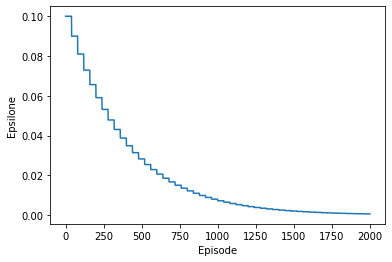

In [0]:
plt.plot([ EPSILON*((1-EPSILON)**(i//40)) for i in range(2000)])
plt.xlabel('Episode')
plt.ylabel('Epsilone')

### Running Sarsa and Q-learning 

In [0]:
# Use multiple runs instead of a single run and a sliding window
# With a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def compare_rl():
    # episodes of each run
    episodes = 5000 #2000
    EPOCH = 40

    # perform 100 independent runs
    runs = 10 #100

    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
        q_q_learning = np.copy(q_sarsa)
        for i in range(0, episodes):
            eps = EPSILON*((1-EPSILON)**(i//EPOCH))
            rewards_sarsa[i] += sarsa(q_sarsa,eps=eps)
            rewards_q_learning[i] += q_learning(q_q_learning, eps=eps)

    # averaging over independt runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # draw reward curves
    #print("[[%s]]" % rewards_sarsa)
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    #plt.ylim([-1, 0])
    plt.legend()
#     Uncomment to save the figures
#     plt.savefig('../images/figure_6_4.png')
#     plt.close()

    # display optimal policy
    #print('Sarsa Optimal Policy:')
    #print_optimal_policy(q_sarsa)
    #print('Q-Learning Optimal Policy:')
    #print_optimal_policy(q_q_learning)
    return q_sarsa, q_q_learning

#### Start the runs

100%|██████████| 10/10 [22:04<00:00, 133.15s/it]


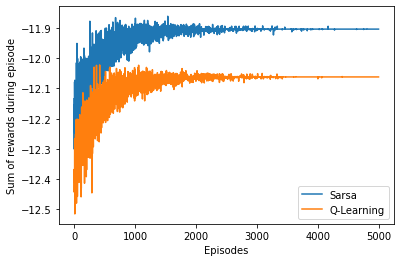

In [0]:
q_sarsa, q_q_learning = compare_rl()
plt.show()